In [1]:
'''
=====Experiment=====
'''
DATASET_NAME = "CIC_IDS_2017"

GRAPH_CONSTRUCTION = 'host'
WINDOW_SIZE = 3250

MULTICLASS = True

LOAD_SAVED = False

FIRST_RUN = not LOAD_SAVED

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader
import joblib

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(project_root)

from Datasets.CIC_IDS_2017.CIC_IDS_2017_config import CIC_IDS_2017_Config as Dataset_Config

EXPERIMENT_NAME = f"strat_window_{GRAPH_CONSTRUCTION}_{WINDOW_SIZE}"

SOURCE_IP_COL_NAME = Dataset_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = Dataset_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = Dataset_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = Dataset_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = Dataset_Config.ATTACK_CLASS_COL_NAME

BENIGN_CLASS_NAME = Dataset_Config.BENIGN_CLASS_NAME

TIME_COLS = Dataset_Config.TIME_COL_NAMES

DROP_COLS = Dataset_Config.DROP_COLS

COLS_TO_NORM = Dataset_Config.COLS_TO_NORM
CATEGORICAL_COLS = Dataset_Config.CATEGORICAL_COLS

label_col = ATTACK_CLASS_COL_NAME   

save_path = os.path.join(project_root, f"Models/E_GraphSAGE_edge/{DATASET_NAME}/saved", EXPERIMENT_NAME)

checkpoint_path = os.path.join(save_path, f"checkpoints.pth")
best_model_path = os.path.join(save_path, f"best_model.pth")

os.makedirs(save_path, exist_ok=True)


In [2]:
if FIRST_RUN:
    csv_file_name = "all_raw"

    data = pd.read_csv(os.path.join(project_root, "Datasets", f"{DATASET_NAME}/All/{csv_file_name}.csv"))

In [3]:
if FIRST_RUN:
    print(data[ATTACK_CLASS_COL_NAME].value_counts())

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack - Brute Force         1507
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [4]:
if FIRST_RUN:
    data.drop(columns=DROP_COLS,inplace=True)
    print(data.columns)

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Min',
       'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Mean',
       'Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'Average Packet Size', 'Fwd Header Length.1', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Active Mean', 'Active Min', 'Label', 'source_file_id'],
      dtype='object')


In [5]:
if FIRST_RUN:
    if GRAPH_CONSTRUCTION == 'endpoint':
        data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
        data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

        # # Combine Port and IP
        data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
        data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

        data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
        data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
        data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

        data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
        converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]

    elif GRAPH_CONSTRUCTION == 'host':
        data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
        converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]
        COLS_TO_NORM = COLS_TO_NORM + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]
    else:
        raise ValueError("Invalid GRAPH_CONSTRUCTION value. Use 'host' or 'endpoint'.")
    

In [6]:
if FIRST_RUN:
    # Clean NaN values
    data.reset_index(drop=True, inplace=True)
    data.replace([np.inf, -np.inf], np.nan,inplace = True)
    data.fillna(0,inplace = True)

In [7]:
if not LOAD_SAVED:
    # Normalize numerical columns
    scaler = StandardScaler()
    print(data[COLS_TO_NORM].describe()) # Check if there's any too large value

    # Check for numeric issues in the columns before normalization
    def check_numeric_issues(df, cols_to_norm):
        for col in cols_to_norm:
            try:
                # Try to coerce to numeric
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
            except Exception as e:
                print(f"❌ Column '{col}' failed with error: {e}")
                print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
                print(f"  - Data type: {df[col].dtype}")
                continue

        print("\n✅ All other columns processed successfully.")

    check_numeric_issues(data, COLS_TO_NORM)

    data[COLS_TO_NORM] = scaler.fit_transform(data[COLS_TO_NORM])

    # Save the scaler for future use
    scaler_path = os.path.join(save_path, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print("Data after normalization:")

       Bwd Packet Length Min  Subflow Fwd Packets  \
count           2.830743e+06         2.830743e+06   
mean            4.104958e+01         9.361160e+00   
std             6.886260e+01         7.496728e+02   
min             0.000000e+00         1.000000e+00   
25%             0.000000e+00         2.000000e+00   
50%             0.000000e+00         2.000000e+00   
75%             7.700000e+01         5.000000e+00   
max             2.896000e+03         2.197590e+05   

       Total Length of Fwd Packets  Fwd Packet Length Mean  \
count                 2.830743e+06            2.830743e+06   
mean                  5.493024e+02            5.820194e+01   
std                   9.993589e+03            1.860912e+02   
min                   0.000000e+00            0.000000e+00   
25%                   1.200000e+01            6.000000e+00   
50%                   6.200000e+01            3.400000e+01   
75%                   1.870000e+02            5.000000e+01   
max                   1.29

In [8]:
if LOAD_SAVED:
    # load scaler
    scaler_path = os.path.join(save_path, "scaler.pkl")
    scaler = joblib.load(scaler_path)

In [9]:
if FIRST_RUN:
    num_classes = 2
    class_map = [0, 1]
    if MULTICLASS:
        le = LabelEncoder()
        attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
        class_map = le.classes_
        print(class_map)
        print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
        data[ATTACK_CLASS_COL_NAME] = attack_labels
        num_classes = len(class_map)
        class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

    class_map_path = os.path.join(save_path, "class_map.pkl")
    labeller_path = os.path.join(save_path, "labeller.pkl")

    joblib.dump(le, labeller_path)
    joblib.dump(class_map, class_map_path)

    BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
    ADVERSARIAL_CLASS_LABEL = len(class_map)

['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack - Brute Force' 'Web Attack - Sql Injection'
 'Web Attack - XSS']
Attack label mapping: {'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack - Brute Force': 12, 'Web Attack - Sql Injection': 13, 'Web Attack - XSS': 14}


In [10]:
if LOAD_SAVED:
    # Save the class map BENIGN_CLASS_LABEL, ADVERSARIAL_CLASS_LABEL
    class_map_path = os.path.join(save_path, "class_map.pkl")
    labeller_path = os.path.join(save_path, "labeller.pkl")

    class_map = joblib.load(class_map_path)
    le = joblib.load(labeller_path)

    BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
    ADVERSARIAL_CLASS_LABEL = len(class_map)

In [11]:
if not LOAD_SAVED:
    # Maintain the order of the rows in the original dataframe
    feature_cols = COLS_TO_NORM + converted_categorical_cols

    print('Feature Columns:', feature_cols)
    num_features = len(feature_cols)
    print('Number of Features:', num_features)

    data['h'] = data[ feature_cols ].values.tolist()
    print(data.head(5))

Feature Columns: ['Bwd Packet Length Min', 'Subflow Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Mean', 'Total Length of Fwd Packets', 'Fwd Packet Length Std', 'Fwd IAT Min', 'Flow IAT Min', 'Flow IAT Mean', 'Bwd Packet Length Std', 'Subflow Fwd Bytes', 'Flow Duration', 'Flow IAT Std', 'Active Min', 'Active Mean', 'Bwd IAT Mean', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'ACK Flag Count', 'Fwd PSH Flags', 'SYN Flag Count', 'Flow Packets/s', 'PSH Flag Count', 'Average Packet Size', 'Source Port', 'Destination Port', 'Protocol_0', 'Protocol_6', 'Protocol_17']
Number of Features: 29
                                   Flow ID         Source IP  Source Port  \
0  192.168.10.5-104.16.207.165-54865-443-6  104.16.207.165_0    -1.824892   
1    192.168.10.5-104.16.28.216-55054-80-6   104.16.28.216_0    -1.841174   
2    192.168.10.5-104.16.28.216-55055-80-6   104.16.28.216_0    -1.841174   
3  192.168.10.16-104.17.241.25-46236-443-6   104.17.241.25_0    -1.824892   
4  1

In [12]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    assert num_edges == G_nx.number_of_edges(), "Number of edges in PyG graph does not match NetworkX graph."

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [13]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y, eval=False):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        if not eval:
            self.class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(labels),
                y=labels
            )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            if not eval:
                count = class_counts_named[cls_label]
                weight = class_weights_named[cls_label]
                print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
            else:   
                count = class_counts_named[cls_label]
                print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}")
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

In [14]:
if FIRST_RUN:
    def generate_graph_datasets(
        df: pd.DataFrame, 
        window_size: int = WINDOW_SIZE, 
        feature_cols=feature_cols,
        ordering_cols= TIME_COLS, 
        label_col=label_col,
        build_graph_func=create_graph,
        ):

        print("All Columns: ", df.columns)
        print("Ordering Columns: ", ordering_cols)
        assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
        assert label_col in df.columns, "Edge label column 'label' is required"
        
        df = df.sort_values(ordering_cols).reset_index(drop=True)
        window_size = int(window_size)
        
        df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

        print("Final Columns: ", df.columns)
        
        label_counts_list = []
        X = []
        y = []

        progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
        for start in progress_bar:
            window_df = df[start: min(start + window_size, len(df))]
            contains_label = window_df[label_col].unique()

            G_pyg = build_graph_func(window_df)

            label_counts = window_df[label_col].value_counts()

            label_counts_list.append(label_counts)
            X.append(G_pyg)
            y.append(contains_label.tolist())

        return StratifiedGraphDataset(X, y)

In [15]:
test_graph_dataset_path = os.path.join(save_path, "test_graph_dataset.pth")
if FIRST_RUN:
    graph_dataset = generate_graph_datasets(data)
    full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)
    th.save(test_graph_dataset, test_graph_dataset_path)

if LOAD_SAVED:
    # Save or Load test_graph_dataset
    if os.path.exists(test_graph_dataset_path):  
        test_graph_dataset = th.load(test_graph_dataset_path, weights_only=False)
    else:       
        raise FileNotFoundError(f"File {test_graph_dataset_path} does not exist. Please run the code to generate the dataset first.")
    

All Columns:  Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Timestamp', 'Flow Duration',
       'Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Min',
       'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Mean',
       'Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'Average Packet Size', 'Fwd Header Length.1', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Active Mean', 'Active Min', 'Label', 'source_file_id', 'Protocol_0',
       'Protocol_6', 'Protocol_17', 'h'],
      dtype='object')
Ordering Columns:  ['Timestamp']
Final Columns:  Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Timestamp', 'Flow Duration',
       'Total Length of Fwd Packets', 'Fwd Packet Length Mean',
   

Generating graphs: 100%|██████████| 871/871 [01:29<00:00,  9.78it/s]


In [16]:
if FIRST_RUN:
    print("Class Distrubution:", data[label_col].value_counts())

    print("Number of graphs after downsampling:", len(graph_dataset))
    graph_dataset.print_class_distribution_and_weights()

    print("Number of training graphs:", len(full_train_graph_dataset))
    full_train_graph_dataset.print_class_distribution_and_weights()

    print("Number of testing graphs:", len(test_graph_dataset))
    test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: Label
0     2273097
4      231073
10     158930
2      128027
3       10293
7        7938
11       5897
6        5796
5        5499
1        1966
12       1507
14        652
9          36
13         21
8          11
Name: count, dtype: int64
Number of graphs after downsampling: 871
Class Counts and Weights:
0   BENIGN         : Count = 2273097   
7   FTP-Patator    : Count = 7938      
11  SSH-Patator    : Count = 5897      
6   DoS slowloris  : Count = 5796      
5   DoS Slowhttptest: Count = 5499      
4   DoS Hulk       : Count = 231073    
3   DoS GoldenEye  : Count = 10293     
8   Heartbleed     : Count = 11        
12  Web Attack - Brute Force: Count = 1507      
14  Web Attack - XSS: Count = 652       
13  Web Attack - Sql Injection: Count = 21        
9   Infiltration   : Count = 36        
1   Bot            : Count = 1966      
10  PortScan       : Count = 158930    
2   DDoS           : Count = 128027    
Number of training graphs: 740
Class Counts and W

In [17]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [18]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
th.cuda.empty_cache()

In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [21]:
from sklearn.metrics import f1_score

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()


In [22]:
if FIRST_RUN:
    def grid_search(graph_dataset, patience, max_epochs, learning_rates, hidden_dims, drop_outs, folds=3):
        global num_features
        
        best_params = {}
        best_f1 = 0
        params_results = {}

        # Precompute the train and validation graphs for all folds
        folds_list = []
        for i in range(folds):
            train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
            folds_list.append((train_graph_dataset, val_graph_dataset))

        for lr in learning_rates:
            for hidden_dim in hidden_dims:
                for drop_out in drop_outs:
                    print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}, drop_out: {drop_out}")
                    fold_f1_scores = []

                    for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                        print(f"Fold {fold + 1}")

                        model = EGraphSAGE(node_in_channels=num_features,
                                        edge_in_channels=num_features,
                                        hidden_channels=hidden_dim,
                                        dropout = drop_out,
                                        out_channels=num_classes).to(device)

                        model.apply(init_weights)

                        # Normalize to stabilize training
                        class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                        print("Class weights:", class_weights)

                        criterion = nn.CrossEntropyLoss(weight=class_weights)
                        optimizer = th.optim.Adam(model.parameters(), lr=lr)
                        scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer,
                            mode='min',
                            factor=0.6,
                            patience=5,
                            min_lr=1e-6,
                        )

                        best_epoch_f1 = 0  # Track the best F1 score for this fold
                        best_val_loss = float('inf')  # Track the best val_loss for this fold
                        patience_counter = 0

                        for epoch in range(max_epochs):
                            try:
                                train_loss = 0
                                val_loss = 0
                                num_train_graphs = len(train_graph_dataset)
                                num_val_graphs = len(val_graph_dataset)

                                model.train()
                                optimizer.zero_grad()
                                for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

                                    G_pyg_train = G_pyg_train.to(device)
                                    G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                    G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                    
                                    out = model(G_pyg_train)
                                    loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                                    train_loss += loss.item()

                                    loss.backward()

                                optimizer.step()
                                

                                test_label_list = []
                                pred_label_list = []

                                model.eval()
                                with th.no_grad():
                                    for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                        G_pyg_val = G_pyg_val.to(device)
                                        G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                        G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                        out = model(G_pyg_val)
                                        loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                                        val_loss += loss.item()

                                        test_label_list.append(G_pyg_val.edge_label.cpu())
                                        pred_label_list.append(out.argmax(dim=1).cpu())

                                test_label = th.cat(test_label_list)
                                pred_label = th.cat(pred_label_list)

                                val_f1 = f1_score(test_label, pred_label, average='weighted')
                                val_f1_micro = f1_score(test_label, pred_label, average='micro')
                                val_f1_macro = f1_score(test_label, pred_label, average='macro')

                                # Schedule step
                                scheduler.step(val_loss)

                                if val_f1 > best_epoch_f1:
                                    best_epoch_f1 = val_f1
                                    print(f"Epoch {epoch}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                                    f"Val F1 (weighted): {val_f1:.4f}, Micro: {val_f1_micro:.4f}, Macro: {val_f1_macro:.4f} "
                                    f"(Best Weighted F1 so far: {best_epoch_f1:.4f})")

                                # Early stopping condition
                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    patience_counter = 0
                                else:
                                    patience_counter += 1

                                if patience_counter >= patience:
                                    print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
                                    break

                            except Exception as e:
                                print(f"An error occurred at epoch {epoch}: {str(e)}")
                                break

                        fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                    
                    avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                    params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                    print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                    if avg_f1 > best_f1:
                        best_f1 = avg_f1
                        best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

        print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
        print("All results:", params_results)

    # grid_search(
    #     full_train_graph_dataset, 
    #     patience=10,
    #     max_epochs=200,
    #     learning_rates=[0.001, 0.005, 0.01, 0.05], 
    #     hidden_dims=[128, 256, 512], 
    #     drop_outs=[0.2, 0.3, 0.4],
    #     folds=3)


In [23]:
if FIRST_RUN:
    train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [24]:
def save_checkpoint():
    global epoch, model, optimizer, scheduler, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs, best_f1, patience_counter, best_val_loss, train_ended, max_epochs, patience
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_f1_history': val_f1_history,
        'saved_model_epochs': saved_model_epochs,
        'best_f1': best_f1,
        # 'patience_counter': patience_counter,
        # 'best_val_loss': best_val_loss,
        'train_ended': train_ended,
        'max_epochs': max_epochs,
        # 'patience': patience
    }
    
    th.save(checkpoint, checkpoint_path)

In [25]:
# Best parameters from the grid search
best_hidden_dim = 512  # Replace with the best hidden_dim found
best_learning_rate = 0.005  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
if FIRST_RUN:

    max_epochs = 200
    # patience = 10

    print("Number of train graphs: ", len(train_graph_dataset))

    # Initialize the model with the best parameters
    model = EGraphSAGE(node_in_channels=num_features, 
                    edge_in_channels=num_features,
                    hidden_channels=best_hidden_dim,
                    dropout = best_drop_out,
                    out_channels=num_classes).to(device)

    model.apply(init_weights)

    # Normalize class weights
    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
    print("Class weights:", class_weights)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
    scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.6,
        patience=5,
        min_lr=1e-6,
    )

    # ===== Load checkpoint if exists =====
    start_epoch = 0
    best_f1 = 0

    # patience_counter = 0
    best_val_loss = float('inf')
    train_ended = False

    train_loss_history = []
    val_loss_history = []
    val_f1_history = []
    saved_model_epochs = []

    if os.path.exists(checkpoint_path):
        checkpoint = th.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        train_ended = checkpoint['train_ended']
        best_f1 = checkpoint['best_f1']

        assert max_epochs == checkpoint['max_epochs'], "Checkpoint max_epochs does not match the current setting."
        # assert patience == checkpoint['patience'], "Checkpoint patience does not match the current setting."

        # patience_counter = checkpoint['patience_counter']
        # best_val_loss = checkpoint['best_val_loss']

        start_epoch = checkpoint['epoch'] + 1

        train_loss_history = checkpoint['train_loss_history']
        val_loss_history = checkpoint['val_loss_history']
        val_f1_history = checkpoint['val_f1_history']
        saved_model_epochs = checkpoint['saved_model_epochs']
        print(f"Resumed training from epoch {start_epoch}")

    if train_ended:
        model.load_state_dict(th.load(best_model_path))
        print("Training has already ended. Loaded the best model state.")
        print("Training history loaded successfully.")

    else:
        # ===== Start Training =====
        num_train_graphs = len(train_graph_dataset)
        num_val_graphs = len(val_graph_dataset)

        for epoch in range(start_epoch, max_epochs):

            model.train()

            train_loss = 0
            val_loss = 0

            optimizer.zero_grad()
            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

                # Move the graph data to the device
                G_pyg_train = G_pyg_train.to(device)
                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

                out = model(G_pyg_train)
                loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                
                train_loss += loss.item()
                loss.backward()

            optimizer.step()
            
            test_label_list = []
            pred_label_list = []

            model.eval()
            with th.no_grad():
                for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
                    G_pyg_val = G_pyg_val.to(device)
                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                    out = model(G_pyg_val)
                    loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                    val_loss += loss.item()

                    test_label_list.append(G_pyg_val.edge_label.cpu())
                    pred_label_list.append(out.argmax(dim=1).cpu())

            test_label = th.cat(test_label_list)
            pred_label = th.cat(pred_label_list)

            val_f1 = f1_score(test_label, pred_label, average='weighted')
            val_f1_micro = f1_score(test_label, pred_label, average='micro')
            val_f1_macro = f1_score(test_label, pred_label, average='macro')

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

            # Schedule step
            scheduler.step(val_loss)

            if val_f1 > best_f1:
                best_f1 = val_f1  # Update the best F1 score for this fold
                best_model_state = model.state_dict()
                saved_model_epochs.append(epoch)

                save_checkpoint()
                th.save(best_model_state, best_model_path)
                print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}, Validation F1 Micro: {val_f1_micro:.4f}, Validation F1 Macro: {val_f1_macro:.4f}')
            
            if epoch % 10 == 0:
                save_checkpoint()

            # # Early stopping condition
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     patience_counter = 0
            # else:
            #     patience_counter += 1

            # if patience_counter >= patience:
            #     print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
            #     train_ended = True
            #     break

        # Save the trained model
        train_ended = True
        save_checkpoint()
        print("Model training completed and saved.")

Number of train graphs:  629
Class weights: tensor([8.3621e-02, 1.1830e+02, 1.4345e+00, 1.8474e+01, 8.1118e-01, 3.2927e+01,
        3.6149e+01, 2.5126e+01, 1.7035e+04, 5.2416e+03, 1.1002e+00, 3.1991e+01,
        1.3206e+02, 6.4897e+03, 3.6054e+02], device='cuda:0')


Epoch 0 Saved best model. Best F1: 0.7204021768774006
Epoch 0, Train Loss: 2.7538, Validation Loss: 11.6162, Validation F1: 0.7204, Validation F1 Micro: 0.8067, Validation F1 Macro: 0.0638


Epoch 1, Train Loss: 11.1585, Validation Loss: 4.8148, Validation F1: 0.0634, Validation F1 Micro: 0.1515, Validation F1 Macro: 0.0809


Epoch 2, Train Loss: 4.8681, Validation Loss: 2.0058, Validation F1: 0.6192, Validation F1 Micro: 0.5316, Validation F1 Macro: 0.1695


Epoch 3 Saved best model. Best F1: 0.7833496652964158
Epoch 3, Train Loss: 2.0691, Validation Loss: 1.4799, Validation F1: 0.7833, Validation F1 Micro: 0.7731, Validation F1 Macro: 0.2597


Epoch 4, Train Loss: 1.5478, Validation Loss: 1.2622, Validation F1: 0.7253, Validation F1 Micro: 0.7323, Validation F1 Macro: 0.1478


Epoch 5 Saved best model. Best F1: 0.8488610064329773
Epoch 5, Train Loss: 1.3334, Validation Loss: 1.0683, Validation F1: 0.8489, Validation F1 Micro: 0.8824, Validation F1 Macro: 0.1934


Epoch 6 Saved best model. Best F1: 0.9104526779855434
Epoch 6, Train Loss: 1.1770, Validation Loss: 0.9591, Validation F1: 0.9105, Validation F1 Micro: 0.9148, Validation F1 Macro: 0.3577


Epoch 7, Train Loss: 1.0418, Validation Loss: 1.1871, Validation F1: 0.8458, Validation F1 Micro: 0.8820, Validation F1 Macro: 0.1912


Epoch 8 Saved best model. Best F1: 0.9180570777497241
Epoch 8, Train Loss: 1.1967, Validation Loss: 0.9128, Validation F1: 0.9181, Validation F1 Micro: 0.8956, Validation F1 Macro: 0.4422


Epoch 9, Train Loss: 0.9192, Validation Loss: 0.7718, Validation F1: 0.8712, Validation F1 Micro: 0.8413, Validation F1 Macro: 0.4367


Epoch 10 Saved best model. Best F1: 0.9678716841989795
Epoch 10, Train Loss: 0.8005, Validation Loss: 0.5610, Validation F1: 0.9679, Validation F1 Micro: 0.9672, Validation F1 Macro: 0.5172


Epoch 11, Train Loss: 0.6113, Validation Loss: 0.6126, Validation F1: 0.9123, Validation F1 Micro: 0.9237, Validation F1 Macro: 0.3885


Epoch 12, Train Loss: 0.6567, Validation Loss: 0.4799, Validation F1: 0.9608, Validation F1 Micro: 0.9589, Validation F1 Macro: 0.5467


Epoch 13, Train Loss: 0.5005, Validation Loss: 0.4343, Validation F1: 0.9558, Validation F1 Micro: 0.9509, Validation F1 Macro: 0.5264


Epoch 14, Train Loss: 0.4487, Validation Loss: 0.4377, Validation F1: 0.9417, Validation F1 Micro: 0.9366, Validation F1 Macro: 0.5150


Epoch 15, Train Loss: 0.4417, Validation Loss: 0.3915, Validation F1: 0.9637, Validation F1 Micro: 0.9620, Validation F1 Macro: 0.5416


Epoch 16, Train Loss: 0.3910, Validation Loss: 0.3772, Validation F1: 0.9664, Validation F1 Micro: 0.9552, Validation F1 Macro: 0.5351


Epoch 17 Saved best model. Best F1: 0.968043293297842
Epoch 17, Train Loss: 0.3647, Validation Loss: 0.3562, Validation F1: 0.9680, Validation F1 Micro: 0.9641, Validation F1 Macro: 0.5508


Epoch 18 Saved best model. Best F1: 0.9770111464573052
Epoch 18, Train Loss: 0.3418, Validation Loss: 0.3255, Validation F1: 0.9770, Validation F1 Micro: 0.9729, Validation F1 Macro: 0.5713


Epoch 19, Train Loss: 0.3147, Validation Loss: 0.3092, Validation F1: 0.9740, Validation F1 Micro: 0.9601, Validation F1 Macro: 0.5743


Epoch 20, Train Loss: 0.2882, Validation Loss: 0.2942, Validation F1: 0.9717, Validation F1 Micro: 0.9594, Validation F1 Macro: 0.5933


Epoch 21, Train Loss: 0.2723, Validation Loss: 0.2794, Validation F1: 0.9748, Validation F1 Micro: 0.9645, Validation F1 Macro: 0.6059


Epoch 22 Saved best model. Best F1: 0.978837244656469
Epoch 22, Train Loss: 0.2488, Validation Loss: 0.2740, Validation F1: 0.9788, Validation F1 Micro: 0.9692, Validation F1 Macro: 0.5769


Epoch 23, Train Loss: 0.2488, Validation Loss: 0.2610, Validation F1: 0.9734, Validation F1 Micro: 0.9600, Validation F1 Macro: 0.6579


Epoch 24, Train Loss: 0.2216, Validation Loss: 0.2474, Validation F1: 0.9744, Validation F1 Micro: 0.9617, Validation F1 Macro: 0.6729


Epoch 25, Train Loss: 0.2131, Validation Loss: 0.2432, Validation F1: 0.9749, Validation F1 Micro: 0.9623, Validation F1 Macro: 0.6361


Epoch 26, Train Loss: 0.1939, Validation Loss: 0.2408, Validation F1: 0.9726, Validation F1 Micro: 0.9590, Validation F1 Macro: 0.6198


Epoch 27, Train Loss: 0.1798, Validation Loss: 0.2409, Validation F1: 0.9747, Validation F1 Micro: 0.9617, Validation F1 Macro: 0.6046


Epoch 28 Saved best model. Best F1: 0.9805767616815412
Epoch 28, Train Loss: 0.1718, Validation Loss: 0.2402, Validation F1: 0.9806, Validation F1 Micro: 0.9683, Validation F1 Macro: 0.6354


Epoch 29, Train Loss: 0.1615, Validation Loss: 0.2353, Validation F1: 0.9694, Validation F1 Micro: 0.9549, Validation F1 Macro: 0.6143


Epoch 30 Saved best model. Best F1: 0.9815793554155594
Epoch 30, Train Loss: 0.1407, Validation Loss: 0.2277, Validation F1: 0.9816, Validation F1 Micro: 0.9705, Validation F1 Macro: 0.6203


Epoch 31 Saved best model. Best F1: 0.9836077704100223
Epoch 31, Train Loss: 0.1458, Validation Loss: 0.2159, Validation F1: 0.9836, Validation F1 Micro: 0.9747, Validation F1 Macro: 0.6241


Epoch 32, Train Loss: 0.1263, Validation Loss: 0.2008, Validation F1: 0.9806, Validation F1 Micro: 0.9687, Validation F1 Macro: 0.6326


Epoch 33, Train Loss: 0.1168, Validation Loss: 0.1936, Validation F1: 0.9785, Validation F1 Micro: 0.9649, Validation F1 Macro: 0.6287


Epoch 34, Train Loss: 0.1260, Validation Loss: 0.1868, Validation F1: 0.9836, Validation F1 Micro: 0.9740, Validation F1 Macro: 0.6422


Epoch 35 Saved best model. Best F1: 0.9852721447692463
Epoch 35, Train Loss: 0.1021, Validation Loss: 0.2137, Validation F1: 0.9853, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.6780


Epoch 36, Train Loss: 0.1141, Validation Loss: 0.2188, Validation F1: 0.9631, Validation F1 Micro: 0.9367, Validation F1 Macro: 0.5587


Epoch 37, Train Loss: 0.1385, Validation Loss: 0.1874, Validation F1: 0.9813, Validation F1 Micro: 0.9721, Validation F1 Macro: 0.6206


Epoch 38 Saved best model. Best F1: 0.9862241171345228
Epoch 38, Train Loss: 0.0855, Validation Loss: 0.2384, Validation F1: 0.9862, Validation F1 Micro: 0.9855, Validation F1 Macro: 0.6897


Epoch 39, Train Loss: 0.1874, Validation Loss: 0.1815, Validation F1: 0.9764, Validation F1 Micro: 0.9621, Validation F1 Macro: 0.6126


Epoch 40, Train Loss: 0.0967, Validation Loss: 0.2065, Validation F1: 0.9683, Validation F1 Micro: 0.9453, Validation F1 Macro: 0.6185


Epoch 41, Train Loss: 0.1255, Validation Loss: 0.1855, Validation F1: 0.9801, Validation F1 Micro: 0.9676, Validation F1 Macro: 0.6402


Epoch 42, Train Loss: 0.1017, Validation Loss: 0.2130, Validation F1: 0.9853, Validation F1 Micro: 0.9831, Validation F1 Macro: 0.8433


Epoch 43, Train Loss: 0.1058, Validation Loss: 0.2085, Validation F1: 0.9854, Validation F1 Micro: 0.9835, Validation F1 Macro: 0.7757


Epoch 44, Train Loss: 0.1110, Validation Loss: 0.1805, Validation F1: 0.9837, Validation F1 Micro: 0.9742, Validation F1 Macro: 0.6460


Epoch 45, Train Loss: 0.0911, Validation Loss: 0.1835, Validation F1: 0.9742, Validation F1 Micro: 0.9598, Validation F1 Macro: 0.6265


Epoch 46, Train Loss: 0.0975, Validation Loss: 0.2124, Validation F1: 0.9767, Validation F1 Micro: 0.9644, Validation F1 Macro: 0.6344


Epoch 47, Train Loss: 0.0953, Validation Loss: 0.2053, Validation F1: 0.9790, Validation F1 Micro: 0.9741, Validation F1 Macro: 0.6601


Epoch 48, Train Loss: 0.0940, Validation Loss: 0.2245, Validation F1: 0.9834, Validation F1 Micro: 0.9800, Validation F1 Macro: 0.6780


Epoch 49, Train Loss: 0.0886, Validation Loss: 0.2126, Validation F1: 0.9832, Validation F1 Micro: 0.9800, Validation F1 Macro: 0.6733


Epoch 50, Train Loss: 0.0839, Validation Loss: 0.1968, Validation F1: 0.9828, Validation F1 Micro: 0.9790, Validation F1 Macro: 0.6546


Epoch 51, Train Loss: 0.0858, Validation Loss: 0.1886, Validation F1: 0.9828, Validation F1 Micro: 0.9790, Validation F1 Macro: 0.6551


Epoch 52, Train Loss: 0.0886, Validation Loss: 0.1842, Validation F1: 0.9838, Validation F1 Micro: 0.9805, Validation F1 Macro: 0.7635


Epoch 53, Train Loss: 0.0806, Validation Loss: 0.1861, Validation F1: 0.9846, Validation F1 Micro: 0.9819, Validation F1 Macro: 0.7697


Epoch 54, Train Loss: 0.0838, Validation Loss: 0.1873, Validation F1: 0.9850, Validation F1 Micro: 0.9825, Validation F1 Macro: 0.7733


Epoch 55, Train Loss: 0.0802, Validation Loss: 0.1875, Validation F1: 0.9851, Validation F1 Micro: 0.9827, Validation F1 Macro: 0.7690


Epoch 56, Train Loss: 0.0715, Validation Loss: 0.1883, Validation F1: 0.9846, Validation F1 Micro: 0.9823, Validation F1 Macro: 0.6771


Epoch 57, Train Loss: 0.0686, Validation Loss: 0.1872, Validation F1: 0.9844, Validation F1 Micro: 0.9821, Validation F1 Macro: 0.6255


Epoch 58, Train Loss: 0.0684, Validation Loss: 0.1834, Validation F1: 0.9845, Validation F1 Micro: 0.9818, Validation F1 Macro: 0.6244


Epoch 59, Train Loss: 0.0634, Validation Loss: 0.1805, Validation F1: 0.9847, Validation F1 Micro: 0.9818, Validation F1 Macro: 0.6985


Epoch 60, Train Loss: 0.0653, Validation Loss: 0.1773, Validation F1: 0.9845, Validation F1 Micro: 0.9815, Validation F1 Macro: 0.6973


Epoch 61, Train Loss: 0.0636, Validation Loss: 0.1756, Validation F1: 0.9844, Validation F1 Micro: 0.9813, Validation F1 Macro: 0.7011


Epoch 62, Train Loss: 0.0583, Validation Loss: 0.1753, Validation F1: 0.9841, Validation F1 Micro: 0.9812, Validation F1 Macro: 0.7010


Epoch 63, Train Loss: 0.0569, Validation Loss: 0.1765, Validation F1: 0.9845, Validation F1 Micro: 0.9816, Validation F1 Macro: 0.7014


Epoch 64, Train Loss: 0.0591, Validation Loss: 0.1788, Validation F1: 0.9851, Validation F1 Micro: 0.9826, Validation F1 Macro: 0.7186


Epoch 65, Train Loss: 0.0586, Validation Loss: 0.1801, Validation F1: 0.9853, Validation F1 Micro: 0.9829, Validation F1 Macro: 0.7197


Epoch 66, Train Loss: 0.0570, Validation Loss: 0.1782, Validation F1: 0.9855, Validation F1 Micro: 0.9832, Validation F1 Macro: 0.7720


Epoch 67, Train Loss: 0.0567, Validation Loss: 0.1738, Validation F1: 0.9854, Validation F1 Micro: 0.9831, Validation F1 Macro: 0.7715


Epoch 68, Train Loss: 0.0536, Validation Loss: 0.1680, Validation F1: 0.9852, Validation F1 Micro: 0.9829, Validation F1 Macro: 0.7697


Epoch 69, Train Loss: 0.0514, Validation Loss: 0.1625, Validation F1: 0.9850, Validation F1 Micro: 0.9826, Validation F1 Macro: 0.7700


Epoch 70, Train Loss: 0.0500, Validation Loss: 0.1594, Validation F1: 0.9850, Validation F1 Micro: 0.9825, Validation F1 Macro: 0.7699


Epoch 71, Train Loss: 0.0507, Validation Loss: 0.1582, Validation F1: 0.9852, Validation F1 Micro: 0.9828, Validation F1 Macro: 0.7716


Epoch 72, Train Loss: 0.0450, Validation Loss: 0.1590, Validation F1: 0.9853, Validation F1 Micro: 0.9829, Validation F1 Macro: 0.7203


Epoch 73, Train Loss: 0.0521, Validation Loss: 0.1596, Validation F1: 0.9856, Validation F1 Micro: 0.9832, Validation F1 Macro: 0.7227


Epoch 74, Train Loss: 0.0454, Validation Loss: 0.1619, Validation F1: 0.9856, Validation F1 Micro: 0.9833, Validation F1 Macro: 0.7228


Epoch 75, Train Loss: 0.0487, Validation Loss: 0.1621, Validation F1: 0.9857, Validation F1 Micro: 0.9834, Validation F1 Macro: 0.7229


Epoch 76, Train Loss: 0.0468, Validation Loss: 0.1588, Validation F1: 0.9856, Validation F1 Micro: 0.9833, Validation F1 Macro: 0.7227


Epoch 77, Train Loss: 0.0429, Validation Loss: 0.1547, Validation F1: 0.9856, Validation F1 Micro: 0.9833, Validation F1 Macro: 0.7226


Epoch 78, Train Loss: 0.0429, Validation Loss: 0.1498, Validation F1: 0.9856, Validation F1 Micro: 0.9833, Validation F1 Macro: 0.7223


Epoch 79, Train Loss: 0.0416, Validation Loss: 0.1477, Validation F1: 0.9854, Validation F1 Micro: 0.9831, Validation F1 Macro: 0.7195


Epoch 80, Train Loss: 0.0412, Validation Loss: 0.1480, Validation F1: 0.9855, Validation F1 Micro: 0.9833, Validation F1 Macro: 0.7200


Epoch 81, Train Loss: 0.0400, Validation Loss: 0.1497, Validation F1: 0.9857, Validation F1 Micro: 0.9836, Validation F1 Macro: 0.7213


Epoch 82, Train Loss: 0.0400, Validation Loss: 0.1514, Validation F1: 0.9861, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7246


Epoch 83, Train Loss: 0.0374, Validation Loss: 0.1534, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7259


Epoch 84, Train Loss: 0.0403, Validation Loss: 0.1537, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7260


Epoch 85, Train Loss: 0.0381, Validation Loss: 0.1510, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7261


Epoch 86, Train Loss: 0.0380, Validation Loss: 0.1485, Validation F1: 0.9861, Validation F1 Micro: 0.9841, Validation F1 Macro: 0.7248


Epoch 87, Train Loss: 0.0531, Validation Loss: 0.1469, Validation F1: 0.9858, Validation F1 Micro: 0.9835, Validation F1 Macro: 0.7230


Epoch 88, Train Loss: 0.0368, Validation Loss: 0.1467, Validation F1: 0.9855, Validation F1 Micro: 0.9831, Validation F1 Macro: 0.7202


Epoch 89, Train Loss: 0.0367, Validation Loss: 0.1472, Validation F1: 0.9854, Validation F1 Micro: 0.9828, Validation F1 Macro: 0.7198


Epoch 90, Train Loss: 0.0374, Validation Loss: 0.1490, Validation F1: 0.9853, Validation F1 Micro: 0.9827, Validation F1 Macro: 0.7198


Epoch 91, Train Loss: 0.0369, Validation Loss: 0.1510, Validation F1: 0.9855, Validation F1 Micro: 0.9831, Validation F1 Macro: 0.7212


Epoch 92, Train Loss: 0.0379, Validation Loss: 0.1540, Validation F1: 0.9857, Validation F1 Micro: 0.9834, Validation F1 Macro: 0.7230


Epoch 93, Train Loss: 0.0382, Validation Loss: 0.1566, Validation F1: 0.9859, Validation F1 Micro: 0.9836, Validation F1 Macro: 0.7233


Epoch 94, Train Loss: 0.0389, Validation Loss: 0.1573, Validation F1: 0.9860, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.7241


Epoch 95, Train Loss: 0.0396, Validation Loss: 0.1568, Validation F1: 0.9860, Validation F1 Micro: 0.9839, Validation F1 Macro: 0.7251


Epoch 96, Train Loss: 0.0397, Validation Loss: 0.1548, Validation F1: 0.9860, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.7249


Epoch 97, Train Loss: 0.0387, Validation Loss: 0.1523, Validation F1: 0.9860, Validation F1 Micro: 0.9839, Validation F1 Macro: 0.7249


Epoch 98, Train Loss: 0.0398, Validation Loss: 0.1498, Validation F1: 0.9859, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.7244


Epoch 99, Train Loss: 0.0358, Validation Loss: 0.1472, Validation F1: 0.9860, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.7253


Epoch 100, Train Loss: 0.0369, Validation Loss: 0.1453, Validation F1: 0.9860, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.7246


Epoch 101, Train Loss: 0.0409, Validation Loss: 0.1440, Validation F1: 0.9860, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.7247


Epoch 102, Train Loss: 0.0362, Validation Loss: 0.1432, Validation F1: 0.9859, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.7240


Epoch 103, Train Loss: 0.0358, Validation Loss: 0.1432, Validation F1: 0.9860, Validation F1 Micro: 0.9838, Validation F1 Macro: 0.7242


Epoch 104, Train Loss: 0.0384, Validation Loss: 0.1436, Validation F1: 0.9860, Validation F1 Micro: 0.9839, Validation F1 Macro: 0.7248


Epoch 105, Train Loss: 0.0401, Validation Loss: 0.1443, Validation F1: 0.9861, Validation F1 Micro: 0.9841, Validation F1 Macro: 0.7245


Epoch 106, Train Loss: 0.0356, Validation Loss: 0.1448, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7255


Epoch 107 Saved best model. Best F1: 0.986265219856056
Epoch 107, Train Loss: 0.0374, Validation Loss: 0.1453, Validation F1: 0.9863, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7259


Epoch 108 Saved best model. Best F1: 0.9862796125188017
Epoch 108, Train Loss: 0.0362, Validation Loss: 0.1452, Validation F1: 0.9863, Validation F1 Micro: 0.9844, Validation F1 Macro: 0.7260


Epoch 109 Saved best model. Best F1: 0.9863085265503564
Epoch 109, Train Loss: 0.0355, Validation Loss: 0.1455, Validation F1: 0.9863, Validation F1 Micro: 0.9844, Validation F1 Macro: 0.7268


Epoch 110, Train Loss: 0.0356, Validation Loss: 0.1456, Validation F1: 0.9863, Validation F1 Micro: 0.9844, Validation F1 Macro: 0.7268


Epoch 111, Train Loss: 0.0378, Validation Loss: 0.1454, Validation F1: 0.9863, Validation F1 Micro: 0.9844, Validation F1 Macro: 0.7267


Epoch 112, Train Loss: 0.0362, Validation Loss: 0.1452, Validation F1: 0.9863, Validation F1 Micro: 0.9844, Validation F1 Macro: 0.7263


Epoch 113, Train Loss: 0.0364, Validation Loss: 0.1449, Validation F1: 0.9863, Validation F1 Micro: 0.9844, Validation F1 Macro: 0.7264


Epoch 114, Train Loss: 0.0336, Validation Loss: 0.1448, Validation F1: 0.9863, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7264


Epoch 115, Train Loss: 0.0324, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7255


Epoch 116, Train Loss: 0.0348, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7255


Epoch 117, Train Loss: 0.0369, Validation Loss: 0.1452, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7252


Epoch 118, Train Loss: 0.0359, Validation Loss: 0.1454, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7252


Epoch 119, Train Loss: 0.0347, Validation Loss: 0.1453, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 120, Train Loss: 0.0345, Validation Loss: 0.1454, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 121, Train Loss: 0.0331, Validation Loss: 0.1455, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 122, Train Loss: 0.0343, Validation Loss: 0.1455, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 123, Train Loss: 0.0320, Validation Loss: 0.1454, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7239


Epoch 124, Train Loss: 0.0337, Validation Loss: 0.1454, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7239


Epoch 125, Train Loss: 0.0345, Validation Loss: 0.1453, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7237


Epoch 126, Train Loss: 0.0337, Validation Loss: 0.1452, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7236


Epoch 127, Train Loss: 0.0364, Validation Loss: 0.1452, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7236


Epoch 128, Train Loss: 0.0339, Validation Loss: 0.1452, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7236


Epoch 129, Train Loss: 0.0340, Validation Loss: 0.1452, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7236


Epoch 130, Train Loss: 0.0330, Validation Loss: 0.1451, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7236


Epoch 131, Train Loss: 0.0327, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7236


Epoch 132, Train Loss: 0.0353, Validation Loss: 0.1448, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7236


Epoch 133, Train Loss: 0.0340, Validation Loss: 0.1447, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7239


Epoch 134, Train Loss: 0.0351, Validation Loss: 0.1446, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7239


Epoch 135, Train Loss: 0.0335, Validation Loss: 0.1445, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7239


Epoch 136, Train Loss: 0.0342, Validation Loss: 0.1444, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7238


Epoch 137, Train Loss: 0.0357, Validation Loss: 0.1444, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 138, Train Loss: 0.0342, Validation Loss: 0.1443, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 139, Train Loss: 0.0313, Validation Loss: 0.1442, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 140, Train Loss: 0.0316, Validation Loss: 0.1443, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 141, Train Loss: 0.0342, Validation Loss: 0.1443, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 142, Train Loss: 0.0352, Validation Loss: 0.1443, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 143, Train Loss: 0.0322, Validation Loss: 0.1443, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 144, Train Loss: 0.0338, Validation Loss: 0.1444, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 145, Train Loss: 0.0327, Validation Loss: 0.1444, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 146, Train Loss: 0.0311, Validation Loss: 0.1445, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 147, Train Loss: 0.0302, Validation Loss: 0.1446, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7249


Epoch 148, Train Loss: 0.0349, Validation Loss: 0.1446, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 149, Train Loss: 0.0322, Validation Loss: 0.1447, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 150, Train Loss: 0.0337, Validation Loss: 0.1448, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 151, Train Loss: 0.0327, Validation Loss: 0.1448, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 152, Train Loss: 0.0352, Validation Loss: 0.1448, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 153, Train Loss: 0.0357, Validation Loss: 0.1448, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 154, Train Loss: 0.0312, Validation Loss: 0.1448, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 155, Train Loss: 0.0326, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 156, Train Loss: 0.0350, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 157, Train Loss: 0.0341, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 158, Train Loss: 0.0343, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 159, Train Loss: 0.0349, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 160, Train Loss: 0.0319, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 161, Train Loss: 0.0337, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 162, Train Loss: 0.0316, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 163, Train Loss: 0.0344, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 164, Train Loss: 0.0338, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 165, Train Loss: 0.0334, Validation Loss: 0.1449, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 166, Train Loss: 0.0336, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 167, Train Loss: 0.0353, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 168, Train Loss: 0.0326, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 169, Train Loss: 0.0348, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 170, Train Loss: 0.0345, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 171, Train Loss: 0.0319, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 172, Train Loss: 0.0312, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 173, Train Loss: 0.0336, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 174, Train Loss: 0.0333, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 175, Train Loss: 0.0343, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 176, Train Loss: 0.0318, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 177, Train Loss: 0.0358, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 178, Train Loss: 0.0340, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 179, Train Loss: 0.0357, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 180, Train Loss: 0.0336, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 181, Train Loss: 0.0331, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 182, Train Loss: 0.0327, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 183, Train Loss: 0.0310, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 184, Train Loss: 0.0328, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 185, Train Loss: 0.0331, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 186, Train Loss: 0.0317, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 187, Train Loss: 0.0324, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 188, Train Loss: 0.0341, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 189, Train Loss: 0.0355, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 190, Train Loss: 0.0347, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9842, Validation F1 Macro: 0.7250


Epoch 191, Train Loss: 0.0344, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 192, Train Loss: 0.0344, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 193, Train Loss: 0.0343, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 194, Train Loss: 0.0334, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 195, Train Loss: 0.0328, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 196, Train Loss: 0.0321, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 197, Train Loss: 0.0324, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 198, Train Loss: 0.0333, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250


Epoch 199, Train Loss: 0.0320, Validation Loss: 0.1450, Validation F1: 0.9862, Validation F1 Micro: 0.9843, Validation F1 Macro: 0.7250
Model training completed and saved.


In [26]:
def plot_training_process():
    checkpoint = th.load(checkpoint_path)

    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    val_f1_history = checkpoint['val_f1_history']
    saved_model_epochs = checkpoint['saved_model_epochs']

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_loss_history, label='Train Loss', color='blue')
    axs[0].plot(val_loss_history, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1_history:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_loss_history))

    plt.tight_layout()
    plt.show()

200


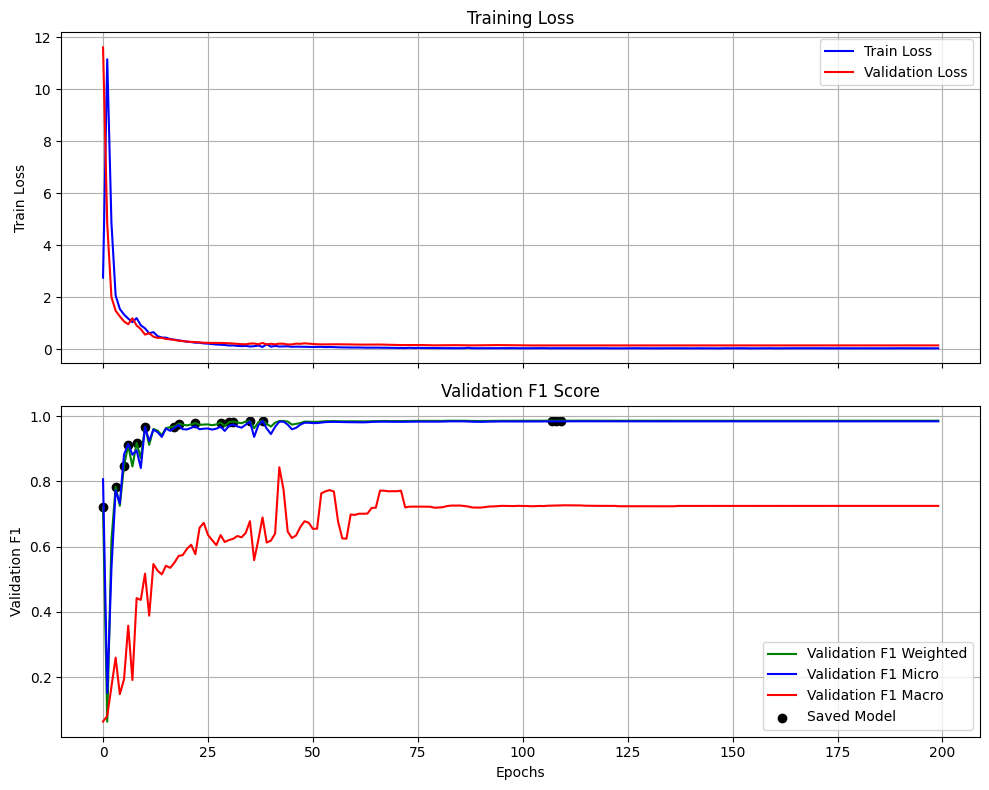

In [27]:
plot_training_process()

In [28]:
import torch
from torch_geometric.utils import degree
from collections import defaultdict

def check_global_avg_degrees_per_class(graph_dataset):
    # Dictionaries to hold total degree sums and counts per class
    total_out_deg = defaultdict(float)
    total_in_deg = defaultdict(float)
    count_out_nodes = defaultdict(int)
    count_in_nodes = defaultdict(int)
    min_out_deg = defaultdict(lambda: float('inf'))
    max_out_deg = defaultdict(lambda: float('-inf'))
    min_in_deg = defaultdict(lambda: float('inf'))
    max_in_deg = defaultdict(lambda: float('-inf'))

    for graph in graph_dataset:
        edge_index = graph.edge_index
        edge_label = graph.edge_label
        num_nodes = graph.num_nodes

        unique_classes = torch.unique(edge_label)

        for cls in unique_classes:
            cls = int(cls)
            mask = (edge_label == cls)

            src_nodes = edge_index[0][mask]
            dst_nodes = edge_index[1][mask]

            out_deg = degree(src_nodes, num_nodes=num_nodes)
            in_deg = degree(dst_nodes, num_nodes=num_nodes)

            involved_src = out_deg > 0
            involved_dst = in_deg > 0

            total_out_deg[cls] += out_deg[involved_src].sum().item()
            total_in_deg[cls] += in_deg[involved_dst].sum().item()
            count_out_nodes[cls] += involved_src.sum().item()
            count_in_nodes[cls] += involved_dst.sum().item()

            if involved_src.any():
                min_out_deg[cls] = min(min_out_deg[cls], out_deg[involved_src].min().item())
                max_out_deg[cls] = max(max_out_deg[cls], out_deg[involved_src].max().item())
            if involved_dst.any():
                min_in_deg[cls] = min(min_in_deg[cls], in_deg[involved_dst].min().item())
                max_in_deg[cls] = max(max_in_deg[cls], in_deg[involved_dst].max().item())

    print("Average, Min, and Max Degrees Across All Graphs:")
    class_degree_report = {}
    for cls in sorted(total_out_deg.keys()):
        avg_out = total_out_deg[cls] / count_out_nodes[cls] if count_out_nodes[cls] > 0 else 0.0
        avg_in = total_in_deg[cls] / count_in_nodes[cls] if count_in_nodes[cls] > 0 else 0.0
        min_out = min_out_deg[cls] if min_out_deg[cls] != float('inf') else 0.0
        max_out = max_out_deg[cls] if max_out_deg[cls] != float('-inf') else 0.0
        min_in = min_in_deg[cls] if min_in_deg[cls] != float('inf') else 0.0
        max_in = max_in_deg[cls] if max_in_deg[cls] != float('-inf') else 0.0

        epsilon = 1e-6 # to avoid division by zero
        avg_influence = (avg_out ** 2) / ((avg_in + epsilon))
        max_influence = (max_out ** 2) / ((min_in + epsilon))
        min_influence = (min_out ** 2) / ((max_in + epsilon))

        print(f"  Attack Class {le.inverse_transform([cls])}:")
        print(f"    Avg Out-Degree (src): {avg_out:.4f} | Min: {min_out:.0f} | Max: {max_out:.0f}")
        print(f"    Avg In-Degree (dst): {avg_in:.4f} | Min: {min_in:.0f} | Max: {max_in:.0f}")
        print(f"    Influence: {avg_influence:.4f} | Min: {min_influence:.4f} | Max: {max_influence:.4f}")

        class_degree_report[le.inverse_transform([cls])[0]] = {
            "avg_out": avg_out,
            "min_out": min_out,
            "max_out": max_out,
            "avg_in": avg_in,
            "min_in": min_in,
            "max_in": max_in,
            "avg_influence": avg_influence,
            "min_influence": min_influence,
            "max_influence": max_influence
        }

    return class_degree_report

class_degree_report = check_global_avg_degrees_per_class(test_graph_dataset)

Average, Min, and Max Degrees Across All Graphs:
  Attack Class ['BENIGN']:
    Avg Out-Degree (src): 15.4354 | Min: 1 | Max: 2570
    Avg In-Degree (dst): 10.0985 | Min: 1 | Max: 1990
    Influence: 23.5927 | Min: 0.0005 | Max: 6604893.3951
  Attack Class ['Bot']:
    Avg Out-Degree (src): 13.7857 | Min: 1 | Max: 147
    Avg In-Degree (dst): 24.1250 | Min: 1 | Max: 169
    Influence: 7.8776 | Min: 0.0059 | Max: 21608.9784
  Attack Class ['DDoS']:
    Avg Out-Degree (src): 1825.9000 | Min: 3 | Max: 3076
    Avg In-Degree (dst): 1825.9000 | Min: 3 | Max: 3076
    Influence: 1825.9000 | Min: 0.0029 | Max: 3153924.2820
  Attack Class ['DoS GoldenEye']:
    Avg Out-Degree (src): 1161.0000 | Min: 1161 | Max: 1161
    Avg In-Degree (dst): 1161.0000 | Min: 1161 | Max: 1161
    Influence: 1161.0000 | Min: 1161.0000 | Max: 1161.0000
  Attack Class ['DoS Hulk']:
    Avg Out-Degree (src): 2754.5000 | Min: 124 | Max: 3230
    Avg In-Degree (dst): 2754.5000 | Min: 124 | Max: 3230
    Influence: 275

In [29]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    # Check if dataset is a list of (data, label) tuples or just data objects
    if isinstance(dataset[0], (list, tuple)):
        data_obj = dataset[0][0]
    else:
        data_obj = dataset[0]

    num_features = data_obj.edge_attr.shape[1]
    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=len(class_map)).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)

    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, labels=range(len(class_map)))
    print(report)
    
    return classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, output_dict=True, labels=range(len(class_map)))


print("Number of test graphs: ", len(test_graph_dataset))
normal_report = eval(test_graph_dataset)


Number of test graphs:  131
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/CIC_IDS_2017/saved/strat_window_host_3250/best_model.pth


inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.9886
class_map ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack - Brute Force' 'Web Attack - Sql Injection'
 'Web Attack - XSS']
[[348864    892     40     26     40     19     88    246    209    195
    1036    498     61     12     72]
 [     8    378      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     3      0  18256      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0   1161      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0  32930      0      0      0      0      0
       0    124      0      0      0]
 [     0      0      0      0      0    254      0      0      0      0
       0      0      0      0      0]
 [   892      0      0      0      0      0      0      0      0      0
     

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
def inject_traffic_to_node(graph, ratio=0.1, num_injected_nodes=1, to_node_type='both', random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # Get all src nodes
    if to_node_type == 'src':
         to_nodes = edge_index[0]

    elif to_node_type == 'dst':
         to_nodes = edge_index[1]

    elif to_node_type == 'both':
         to_nodes = th.cat([edge_index[0], edge_index[1]])

    else:
        raise ValueError("to_node_type must be 'src', 'dst', or 'both'.")

    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []
    
    for i in range(num_to_inject):
        rng = random.Random(random_seed + i)  # ensure different seed per iteration
        src = rng.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
        dst = rng.choice(to_nodes.tolist())  # to existing nodes

        new_edges.append([src, dst])
        attr = th.rand(feature_dim)  # random feature for the new edge
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

    return new_graph



In [31]:
# Inject Attack Traffic to Attacker Nodes
inject_both_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='both') for g in test_graph_dataset]
inject_both_report = eval(inject_both_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/CIC_IDS_2017/saved/strat_window_host_3250/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.8298
Adversarial confusion matrix: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0  

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [32]:
# Inject Attack Traffic to Attacker Nodes
inject_src_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='src') for g in test_graph_dataset]
inject_src_report = eval(inject_src_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/CIC_IDS_2017/saved/strat_window_host_3250/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.8240
Adversarial confusion matrix: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0  

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Inject Attack Traffic to Attacker Nodes
inject_dst_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='dst') for g in test_graph_dataset]
inject_dst_report = eval(inject_dst_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/CIC_IDS_2017/saved/strat_window_host_3250/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.9000
Adversarial confusion matrix: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0  

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Edge Attribute Perturbation
def perturb_edge_attributes(graph, affected_edge_ratio=0.1, perturbation_ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()

    num_edges = edge_index.size(1)
    feature_dim = edge_attr.size(1)

    # Randomly select edges to perturb
    num_to_perturb = max(1, int(affected_edge_ratio * num_edges))
    rng = random.Random(random_seed)
    indices_to_perturb = rng.sample(range(num_edges), num_to_perturb)

    for idx in indices_to_perturb:
        # Perturb the edge attributes by adding noise
        noise = th.randn(feature_dim) * perturbation_ratio  # Adjust the scale of noise as needed
        edge_attr[idx] += noise

    # Create a new graph with perturbed attributes
    perturbed_graph = Data(edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label, x=graph.x)

    return perturbed_graph

In [35]:
# Edge Attribute Perturbation
edge_perturb_graph_dataset = [perturb_edge_attributes(g.cpu(), affected_edge_ratio=1, perturbation_ratio=1) for g in test_graph_dataset]
edge_perturb_report = eval(edge_perturb_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/CIC_IDS_2017/saved/strat_window_host_3250/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.9816
Adversarial confusion matrix: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
class_map ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack - Brute Force' 'Web Attack - Sql Injection'
 'Web Attack - XSS']
[[346555   3044     56     25     97     18     89    205    250    389
    1065    269    168     13     55]
 [    22    363      0      0      0

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
# Inject Random Edges
def inject_random_edges(graph, ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_nodes = x.size(0)
    feature_dim = graph.x.size(1)

    new_edge_indices = []
    new_edge_attrs = []
    new_edge_labels = []

    num_edges = edge_index.size(1)
    num_injected_edges = max(1, int(ratio * num_edges))

    for i in range(num_injected_edges):
        rng = random.Random(random_seed + i)  # ensure different seed per edge
        src = rng.randint(0, num_nodes - 1)  # Random source node
        dst = rng.randint(0, num_nodes - 1)  # Random destination node

        new_edge_indices.append([src, dst])
        new_edge_attrs.append(th.rand(feature_dim))  # Random feature for the new edge
        new_edge_labels.append(ADVERSARIAL_CLASS_LABEL)

    if new_edge_indices:
        new_edge_indices = th.tensor(new_edge_indices, dtype=th.long).t().contiguous()
        new_edge_attrs = th.stack(new_edge_attrs)
        new_edge_labels = th.tensor(new_edge_labels, dtype=th.long)

        edge_index = th.cat([edge_index, new_edge_indices], dim=1)
        edge_attr = th.cat([edge_attr, new_edge_attrs], dim=0)
        edge_label = th.cat([edge_label, new_edge_labels], dim=0)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label)

In [37]:
# Inject Random Edges
random_edge_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
random_edge_report = eval(random_edge_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/CIC_IDS_2017/saved/strat_window_host_3250/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.8740
Adversarial confusion matrix: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0  

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [38]:
def compare_overall_metrics(baseline_report, adversarial_reports, class_degree_report):
    rows = []   
    metrics = ['precision', 'recall', 'f1-score']
    eplison = 1e-10  # To avoid division by zero

    for label in list(class_map) + ['macro avg', 'weighted avg']:
        row = {"Class": label}
        row['Class'] = label
        row['Min Influence'] = class_degree_report[label]['min_influence'] if label in class_degree_report else 0.0
        row['Avg Influence'] = class_degree_report[label]['avg_influence'] if label in class_degree_report else 0.0
        row['Max Influence'] = class_degree_report[label]['max_influence'] if label in class_degree_report else 0.0
        for metric in metrics:
            baseline_val = baseline_report[label][metric]
            row[f"Normal {metric}"] = baseline_val
            for name, report in adversarial_reports.items():
                adv_val = report[label][metric]
                row[f"{name} {metric}"] = adv_val
                row[f"{name} {metric} Drop (%)"] = ((baseline_val - adv_val) / (baseline_val + eplison)) * 100
        row['support'] = int(baseline_report[label]['support'])
        rows.append(row)

    return pd.DataFrame(rows)

adversarial_reports = {
    "To Both": inject_both_report,
    "To Src": inject_src_report,
    "To Dst": inject_dst_report,
    "Edge Perturbation": edge_perturb_report,
    "Random Edge": random_edge_report,
}

comparison_df = compare_overall_metrics(normal_report, adversarial_reports, class_degree_report)

class_col = comparison_df['Class']
support_df = comparison_df['support']
normal_cols = [col for col in comparison_df.columns if col.startswith('Normal')] 
influence_cols = [col for col in comparison_df.columns if col.endswith('Influence')] 
influence_df = comparison_df[influence_cols]
f1_cols = [col for col in comparison_df.columns if col.endswith('f1-score')]
f1_drop_cols = [col for col in comparison_df.columns if col.endswith('f1-score Drop (%)')]

baselines_df = pd.concat([class_col, support_df, influence_df], axis=1)

f1_df = pd.concat([baselines_df, comparison_df[f1_cols]], axis=1)
f1_drop_df = pd.concat([baselines_df, comparison_df[f1_drop_cols]], axis=1)

print("Comparison of Overall Metrics:")
display(comparison_df.style.set_caption("Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))


Comparison of Overall Metrics:


,Class,Min Influence,Avg Influence,Max Influence,Normal precision,To Both precision,To Both precision Drop (%),To Src precision,To Src precision Drop (%),To Dst precision,To Dst precision Drop (%),Edge Perturbation precision,Edge Perturbation precision Drop (%),Random Edge precision,Random Edge precision Drop (%),Normal recall,To Both recall,To Both recall Drop (%),To Src recall,To Src recall Drop (%),To Dst recall,To Dst recall Drop (%),Edge Perturbation recall,Edge Perturbation recall Drop (%),Random Edge recall,Random Edge recall Drop (%),Normal f1-score,To Both f1-score,To Both f1-score Drop (%),To Src f1-score,To Src f1-score Drop (%),To Dst f1-score,To Dst f1-score Drop (%),Edge Perturbation f1-score,Edge Perturbation f1-score Drop (%),Random Edge f1-score,Random Edge f1-score Drop (%),support
0,BENIGN,0.00,23.59,6604893.40,1.00,0.91,8.55,0.90,9.54,1.00,0.00,0.99,0.26,0.97,2.68,0.99,0.99,-0.09,1.00,-0.57,0.99,-0.16,0.98,0.66,0.99,-0.23,0.99,0.95,4.41,0.95,4.74,0.99,-0.08,0.99,0.46,0.98,1.24,352298
1,Bot,0.01,7.88,21608.98,0.30,0.13,55.47,0.30,0.73,0.35,-16.62,0.11,64.20,0.38,-27.09,0.98,0.97,1.06,0.96,1.59,0.98,0.00,0.94,3.97,0.97,0.53,0.46,0.23,48.93,0.45,0.93,0.51,-12.27,0.19,58.07,0.54,-19.37,386
2,DDoS,0.00,1825.90,3153924.28,1.00,1.00,0.02,1.00,0.02,1.00,-0.03,1.00,0.09,1.00,0.20,1.00,0.68,32.04,0.68,32.04,1.00,0.00,1.00,0.00,0.68,32.04,1.00,0.81,19.07,0.81,19.07,1.00,-0.01,1.00,0.04,0.81,19.13,18259
3,DoS GoldenEye,1161.00,1161.00,1161.00,0.98,1.00,-2.15,1.00,-2.15,0.98,-0.34,0.98,-0.08,0.99,-1.19,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.99,1.00,-1.08,1.00,-1.08,0.99,-0.17,0.99,-0.04,0.99,-0.60,1161
4,DoS Hulk,4.76,2754.50,84136.29,1.00,1.00,-0.03,1.00,0.03,1.00,-0.03,1.00,0.17,0.92,7.78,1.00,0.71,28.48,0.62,37.76,1.00,0.00,1.00,-0.38,1.00,0.00,1.00,0.83,16.61,0.77,23.31,1.00,-0.02,1.00,-0.10,0.96,4.04,33054
5,DoS Slowhttptest,112.76,127.00,142.82,0.93,0.96,-3.02,0.97,-3.80,0.94,-0.74,0.93,-0.37,0.89,4.88,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.96,0.98,-1.54,0.98,-1.93,0.97,-0.38,0.97,-0.19,0.94,2.59,254
6,DoS slowloris,90.98,446.00,1733.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,892
7,FTP-Patator,0.68,266.20,10525.23,0.84,0.99,-18.09,0.00,100.00,0.91,-8.11,0.87,-2.70,0.86,-1.63,0.99,0.99,0.00,0.00,100.00,0.99,0.00,0.99,0.00,0.99,0.00,0.91,0.99,-9.01,0.00,100.00,0.95,-4.22,0.92,-1.44,0.92,-0.87,1331
8,Heartbleed,1.00,1.00,1.00,0.00,0.00,100.00,0.00,100.00,0.01,-10.53,0.00,16.33,0.00,100.00,1.00,0.00,100.00,0.00,100.00,1.00,0.00,1.00,0.00,0.00,100.00,0.01,0.00,100.00,0.00,100.00,0.01,-10.47,0.01,16.27,0.00,100.00,1
9,Infiltration,0.25,1.75,16.00,0.03,0.04,-21.82,0.03,-7.37,0.04,-44.60,0.02,49.11,0.04,-30.52,0.86,0.86,0.00,0.71,16.67,0.86,0.00,0.86,0.00,0.86,0.00,0.06,0.07,-20.93,0.06,-6.34,0.08,-42.47,0.03,48.26,0.07,-29.19,7


In [39]:
# Check F1 Scores
display(f1_df.style.background_gradient(cmap='Greens', subset=f1_cols, axis=0).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,Normal f1-score,To Both f1-score,To Src f1-score,To Dst f1-score,Edge Perturbation f1-score,Random Edge f1-score
0,BENIGN,352298,0.00,23.59,6604893.40,0.99,0.95,0.95,0.99,0.99,0.98
1,Bot,386,0.01,7.88,21608.98,0.46,0.23,0.45,0.51,0.19,0.54
2,DDoS,18259,0.00,1825.90,3153924.28,1.00,0.81,0.81,1.00,1.00,0.81
3,DoS GoldenEye,1161,1161.00,1161.00,1161.00,0.99,1.00,1.00,0.99,0.99,0.99
4,DoS Hulk,33054,4.76,2754.50,84136.29,1.00,0.83,0.77,1.00,1.00,0.96
5,DoS Slowhttptest,254,112.76,127.00,142.82,0.96,0.98,0.98,0.97,0.97,0.94
6,DoS slowloris,892,90.98,446.00,1733.34,0.00,0.00,0.00,0.00,0.00,0.00
7,FTP-Patator,1331,0.68,266.20,10525.23,0.91,0.99,0.00,0.95,0.92,0.92
8,Heartbleed,1,1.00,1.00,1.00,0.01,0.00,0.00,0.01,0.01,0.00
9,Infiltration,7,0.25,1.75,16.00,0.06,0.07,0.06,0.08,0.03,0.07


In [40]:
# Compare Drops per Adversarial Attack
display(f1_drop_df[f1_drop_df['Class'] == 'weighted avg'].style.background_gradient(cmap='Reds', subset=f1_drop_cols, axis=None).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,To Both f1-score Drop (%),To Src f1-score Drop (%),To Dst f1-score Drop (%),Edge Perturbation f1-score Drop (%),Random Edge f1-score Drop (%)
16,weighted avg,425750,0.00,0.00,0.00,9.72,10.80,-0.10,0.48,3.09


In [41]:
# Compare Drops per Class
display(f1_drop_df.style.background_gradient(cmap='Reds', subset=f1_drop_cols).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,To Both f1-score Drop (%),To Src f1-score Drop (%),To Dst f1-score Drop (%),Edge Perturbation f1-score Drop (%),Random Edge f1-score Drop (%)
0,BENIGN,352298,0.00,23.59,6604893.40,4.41,4.74,-0.08,0.46,1.24
1,Bot,386,0.01,7.88,21608.98,48.93,0.93,-12.27,58.07,-19.37
2,DDoS,18259,0.00,1825.90,3153924.28,19.07,19.07,-0.01,0.04,19.13
3,DoS GoldenEye,1161,1161.00,1161.00,1161.00,-1.08,-1.08,-0.17,-0.04,-0.60
4,DoS Hulk,33054,4.76,2754.50,84136.29,16.61,23.31,-0.02,-0.10,4.04
5,DoS Slowhttptest,254,112.76,127.00,142.82,-1.54,-1.93,-0.38,-0.19,2.59
6,DoS slowloris,892,90.98,446.00,1733.34,0.00,0.00,0.00,0.00,0.00
7,FTP-Patator,1331,0.68,266.20,10525.23,-9.01,100.00,-4.22,-1.44,-0.87
8,Heartbleed,1,1.00,1.00,1.00,100.00,100.00,-10.47,16.27,100.00
9,Infiltration,7,0.25,1.75,16.00,-20.93,-6.34,-42.47,48.26,-29.19


In [42]:
from collections import defaultdict
from pprint import pformat

def round_tuple(t):
    return tuple(round(x, 2) for x in t)

def print_results(class_degree_report, comparison_df):
    report_dict = defaultdict(dict)

    for class_name, metrics in class_degree_report.items():
        report_dict[class_name] = {
            "out_degree": round_tuple((metrics['min_out'], metrics['avg_out'], metrics['max_out'])),
            "in_degree": round_tuple((metrics['min_in'], metrics['avg_in'], metrics['max_in']))
        }

    for _, row in comparison_df.iterrows():
        class_name = row['Class']
        if class_name == 'weighted avg':
            class_name = 'Weighted Average'
        if class_name == 'macro avg':
            class_name = 'Macro Average'
        report_dict[class_name].update({
            "support": row['support'],
            "normal_f1": round(row['Normal f1-score'], 2),
            "to_both_f1": round(row['To Both f1-score'], 2),
            "to_src_f1": round(row['To Src f1-score'], 2),
            "to_dst_f1": round(row['To Dst f1-score'], 2),
            "edge_perturb_f1": round(row['Edge Perturbation f1-score'], 2),
            "random_edge_f1": round(row['Random Edge f1-score'], 2),
        })

    print(pformat(dict(report_dict), sort_dicts=False, indent=1))

print_results(class_degree_report, comparison_df)

{'BENIGN': {'out_degree': (1.0, 15.44, 2570.0),
            'in_degree': (1.0, 10.1, 1990.0),
            'support': 352298,
            'normal_f1': 0.99,
            'to_both_f1': 0.95,
            'to_src_f1': 0.95,
            'to_dst_f1': 0.99,
            'edge_perturb_f1': 0.99,
            'random_edge_f1': 0.98},
 'Bot': {'out_degree': (1.0, 13.79, 147.0),
         'in_degree': (1.0, 24.12, 169.0),
         'support': 386,
         'normal_f1': 0.46,
         'to_both_f1': 0.23,
         'to_src_f1': 0.45,
         'to_dst_f1': 0.51,
         'edge_perturb_f1': 0.19,
         'random_edge_f1': 0.54},
 'DDoS': {'out_degree': (3.0, 1825.9, 3076.0),
          'in_degree': (3.0, 1825.9, 3076.0),
          'support': 18259,
          'normal_f1': 1.0,
          'to_both_f1': 0.81,
          'to_src_f1': 0.81,
          'to_dst_f1': 1.0,
          'edge_perturb_f1': 1.0,
          'random_edge_f1': 0.81},
 'DoS GoldenEye': {'out_degree': (1161.0, 1161.0, 1161.0),
                   